In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten ,MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [4]:
path  = "/kaggle/input/fer2013/"

In [5]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

,filename,partition,label
0,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
...,...,...,...
35882,/kaggle/input/fer2013/train/happy/Training_188...,train,happy
35883,/kaggle/input/fer2013/train/happy/Training_165...,train,happy
35884,/kaggle/input/fer2013/train/happy/Training_108...,train,happy
35885,/kaggle/input/fer2013/train/happy/Training_304...,train,happy


In [6]:
image_generator=ImageDataGenerator(rescale=1/255)


Training = image_generator.flow_from_directory('/kaggle/input/fer2013/train',target_size=(224, 224),  
    batch_size=64,class_mode='categorical' )


Test = image_generator.flow_from_directory('/kaggle/input/fer2013/test' ,target_size=(224, 224),  
    batch_size=64,class_mode='categorical' )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
resnet = ResNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

predictions = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.models.Model(inputs=resnet.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
for layer in resnet.layers:
    layer.trainable = False

In [11]:
train_step=Training.n//Training.batch_size
test_step=Test.n//Test.batch_size

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience= 5,
                          verbose=1,
                          restore_best_weights=True
                          )

model_checkpoint = ModelCheckpoint('model_ResNet.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")

callbacks_list = [early_stopping,reduce_learningrate,model_checkpoint]

history = model.fit(Training,
          steps_per_epoch=train_step,
          epochs=10,
          validation_data=Test,
          validation_steps=test_step,
          callbacks=callbacks_list)

Epoch 1/10


I0000 00:00:1708118854.001999      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 [==============================] - ETA: 0s - loss: 1.3069 - accuracy: 0.5065
Epoch 1: val_accuracy improved from -inf to 0.47042, saving model to model_ResNet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 271s 516ms/step - loss: 1.3069 - accuracy: 0.5065 - val_loss: 1.3958 - val_accuracy: 0.4704 - lr: 8.0000e-04
Epoch 2/10
448/448 [==============================] - ETA: 0s - loss: 1.0965 - accuracy: 0.5882
Epoch 2: val_accuracy improved from 0.47042 to 0.49177, saving model to model_ResNet.h5
448/448 [==============================] - 167s 373ms/step - loss: 1.0965 - accuracy: 0.5882 - val_loss: 1.3911 - val_accuracy: 0.4918 - lr: 8.0000e-04
Epoch 3/10
448/448 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.6322
Epoch 3: val_accuracy improved from 0.49177 to 0.56041, saving model to model_ResNet.h5
448/448 [==============================] - 167s 372ms/step - loss: 0.9862 - accuracy: 0.6322 - val_loss: 1.1776 - val_accuracy: 0.5604 - lr: 8.0000e-04
Epoch 4/10
448/448 [==============================] - ETA: 0s - loss: 0.8991 - accuracy: 0.6641
Epoch 4: val_accuracy did not improve from 0.56041
448/448 [====================

In [13]:
# Loading the best fit model 
model.save('ResNet_model.h5')
from keras.models import load_model
model = load_model("ResNet_model.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [15]:
score = model.evaluate(Test)
print(score)

113/113 [==============================] - 21s 172ms/step - loss: 1.7129 - accuracy: 0.6477
[1.7129002809524536, 0.6476734280586243]


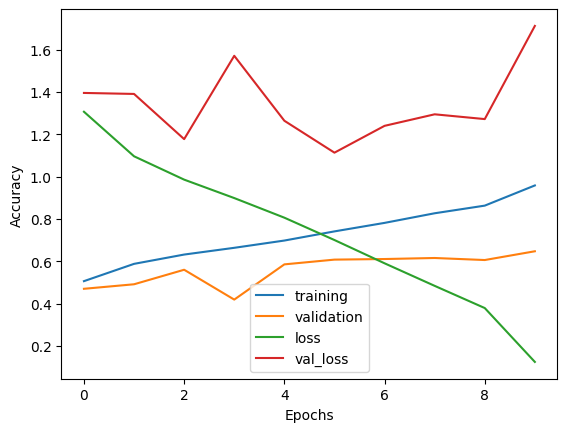

In [16]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'happy')

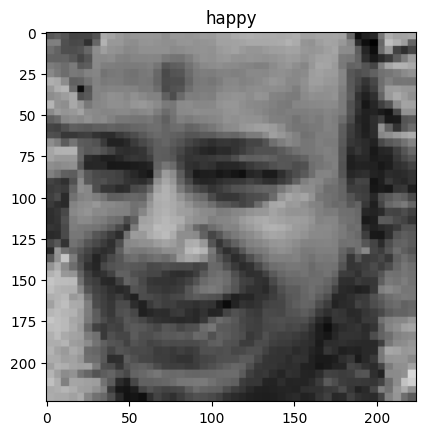

In [20]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[1],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])

1/1 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'surprise')

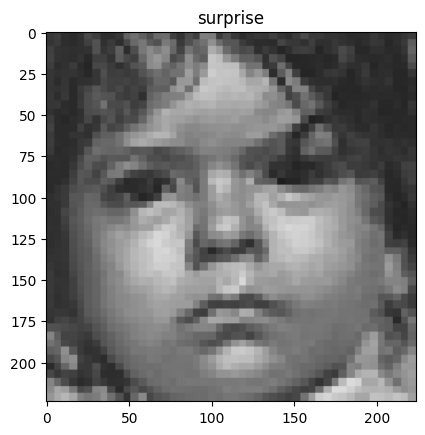

In [21]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[50],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'sad')

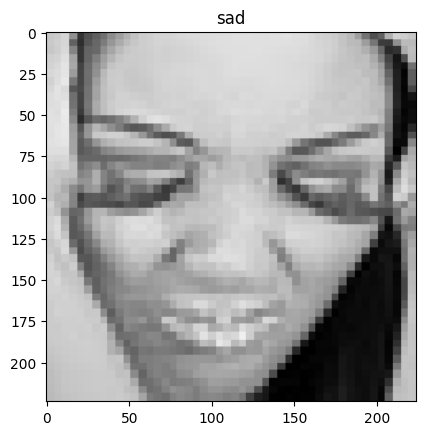

In [22]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[40],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])